### 1. 属性x的信息定义为
$$
    l(x_i) = -log_{2}{p(x_i)}
$$

### 2. 信息熵
$$
    H = -\sum_{i=1}^{n}p(x_i)log_{2}{p(x_i)}
$$

In [18]:
from math import log
#计算香农熵
def calcShannonEntropy(dataSet):
    numEntries = len(dataSet)
    labelCounts = {}
    for rowVec in dataSet:
        currentLabel = rowVec[-1]
        if currentLabel not in labelCounts.keys():
            labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1
    shannonEnt = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key]) / numEntries
        shannonEnt -= prob * log(prob, 2)
    return shannonEnt

In [21]:
#给定列划分数据集,因为python里函数是引用传递，所以为了避免对原数据的改变，需要创个新列表
def splitDataSet(dataSet, axis, value):
    reDataSet = []
    for rowVec in dataSet:
        if rowVec[axis] == value:
            reducedRowVec = rowVec[:axis]
            reducedRowVec.extend(rowVec[axis+1:])
            reDataSet.append(reducedRowVec)
    return reDataSet
            

In [16]:
splitDataSet(dataSet, 0, 0)

[[1, 'n'], [1, 'n']]

In [24]:
#选择最好的数据集划分方式
def chooseBestFeatureToSplit(dataSet):
    numFeatures = len(dataSet[0]) - 1
    baseEntropy = calcShannonEntropy(dataSet)
    bestInfoGain = 0.0; bestFeature = -1
    for i in range(numFeatures):
        featList = [example[i] for example in dataSet]
        uniqueVals = set(featList)
        newEntropy = 0.0
        for value in uniqueVals:
            subDataSet = splitDataSet(dataSet, i, value)
            prob = len(subDataSet) / float(len(dataSet))
            newEntropy += prob * calcShannonEntropy(subDataSet)
        infoGain = baseEntropy - newEntropy
        #信息熵代表了数据的无序程度，熵越大，越无序；信息增益是熵的减少
        if infoGain > bestInfoGain:
            bestInfoGain = infoGain
            bestFeature = i
    return bestFeature


0

In [25]:
import operator
#多数投票，返回类列表中出现次数最多的类
def majorityCount(classList):
    classCount = {}
    for vote in classList:
        if vote not in classCount.keys(): classCount[vote] = 0
        classCount[vote] += 1
    sortedClassCount = sorted(classCount.items(), key=operator.getitem(0), reverse=True)
    return sortedClassCount[0][0]

In [79]:
#创建树，这里的输入labels是指属性的标签，如“No surfacing”
def createTree(dataSet, labels):
    classList = [example[-1] for example in dataSet]
    #特征都为同一类别，直接返回该类别
    if classList.count(classList[0]) == len(dataSet):
        return classList[0]
    #特征数为1，则所有特征都已遍历完，返回最多的那个类别
    if len(dataSet[0]) == 1:
        return majorityCount(classList)
    bestFeat = chooseBestFeatureToSplit(dataSet)
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel:{}}
    del(labels[bestFeat])
    featValues = [example[bestFeat] for example in dataSet]
    uniqueValues = set(featValues)
    for value in uniqueValues:
        subLabels = labels[:]
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat, value), subLabels)
    return myTree

def createDataSet():
    dataSet = [[1,1,'y'],[1,1,'y'],[1,0,'n'],[0,1,'n'],[0,1,'n']]
    labels = ['no surfacing','flippers']
    return dataSet, labels
    

In [80]:
dataSet, labels = createDataSet()
createTree(dataSet, labels)

{'no surfacing': {0: 'n', 1: {'flippers': {0: 'n', 1: 'y'}}}}

In [48]:
import matplotlib.pyplot as plt
import matplotlib as mpl
#显示图
%matplotlib inline
mpl.rcParams['font.sans-serif']=['SimHei'] #设置字体
decisionNode = dict(boxstyle="sawtooth", fc="0.8")
leafNode = dict(boxstyle="round4", fc="0.8")
arrow_args = dict(arrowstyle="<-")

def plotNode(nodeText, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeText, xy=parentPt, xycoords='axes fraction',\
                           xytext=centerPt, textcoords='axes fraction',\
                           va="center", ha="center", bbox=nodeType, arrowprops=arrow_args)


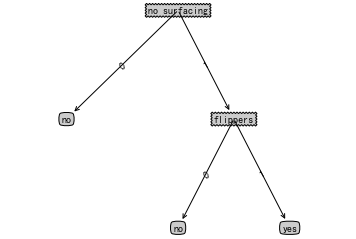

0.64


In [92]:
#得到树的叶子节点个数
def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            numLeafs += getNumLeafs(secondDict[key])
        else: numLeafs += 1
    return numLeafs

#获取树的深度
def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else: thisDepth = 1
        if thisDepth > maxDepth: maxDepth = thisDepth
    return maxDepth

def retrieveTree(i):
    listOfTrees =[{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}},
                  {'no surfacing': {0: 'no', 1: {'flippers': {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}
                  ]
    return listOfTrees[i]

#画两个节点之间的文本
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString, va="center", ha="center", rotation=30)

def plotTree(myTree, parentPt, nodeTxt):#if the first key tells you what feat was split on
    numLeafs = getNumLeafs(myTree)  #this determines the x width of this tree
    depth = getTreeDepth(myTree)
    firstStr = list(myTree.keys())[0]     #the text label for this node should be this
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':#test to see if the nodes are dictonaires, if not they are leaf nodes   
            plotTree(secondDict[key],cntrPt,str(key))        #recursion
        else:   #it's a leaf node print the leaf node
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD
#if you do get a dictonary you know it's a tree, and the first element will be another dict

def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)    #no ticks
    #createPlot.ax1 = plt.subplot(111, frameon=False) #ticks for demo puropses 
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5/plotTree.totalW; plotTree.yOff = 1.0;
    plotTree(inTree, (0.5,1.0), '')
    plt.show()
    
mytree = retrieveTree(0)
createPlot(mytree)
print(3.84/2.0/3)

In [81]:
#输入：树，特征标签，测试向量（就是决策树的路径，如[0,1]）
def classify(inputTree, featLabels, testVec):
    firstStr = list(inputTree.keys())[0]
    secondDict = inputTree[firstStr]
    featIndex = featLabels.index(firstStr)
    for key in secondDict.keys():
        if testVec[featIndex] == key:
            if type(secondDict[key]).__name__ == 'dict':
                classLabel = classify(secondDict[key], featLabels, testVec)
            else: classLabel = secondDict[key]
    return classLabel

dataSet, labels = createDataSet()
classify(mytree, labels, [1,1])

'yes'

In [87]:
#利用pikle存储
def storeTree(inputTree, filename):
    import pickle
    fw = open(filename, "wb")
    pickle.dump(inputTree, fw)
    fw.close()
    
def grabTree(filename):
    import pickle
    fr = open(filename, 'rb')
    return pickle.load(fr)

storeTree(mytree, "mytree.txt")
grabTree("mytree.txt")

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

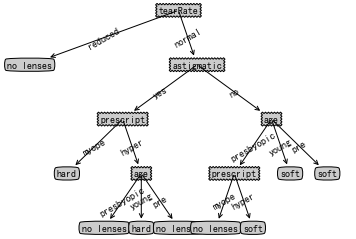

In [93]:
#加载隐形眼镜数据
fr = open('lenses.txt')
lenses = [inst.strip().split('\t') for inst in fr.readlines()]
lensesLabels = ['age', 'prescript', 'astigmatic', 'tearRate']
lensesTree = createTree(lenses, lensesLabels)
createPlot(lensesTree)